In [ ]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
!pip install ekphrasis
!pip install tweet-preprocessor
import preprocessor as p
import re
from textblob import TextBlob
import seaborn as sns
from scipy.stats import pointbiserialr
import tensorflow as tf

!pip install textblob
!python -m textblob.download_corpora

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-d

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing merged datasets from google drive

user = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/train/user (1).csv')
tweet = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/train/tweet (1).csv')

In [ ]:
user['created_at'] = user['created_at'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
tweet['created_at'] = tweet['created_at'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
user.head()

,userId,name,screen_name,tweetId,verfifed,followers_count,statuses_count,friends_count,favourites_count,listed_count,location,created_at,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,url
0,14075928,The Onion,TheOnion,273182568298450945,True,11758300,80911,7,3,68775,NaN,2008-03-04 02:48:37,http://pbs.twimg.com/profile_images/8753920681...,http://abs.twimg.com/images/themes/theme3/bg.gif,False,False,True,https://t.co/EIF811CxOS
1,14075928,The Onion,TheOnion,273278761909239808,True,11758329,80911,7,3,68775,NaN,2008-03-04 02:48:37,http://pbs.twimg.com/profile_images/8753920681...,http://abs.twimg.com/images/themes/theme3/bg.gif,False,False,True,https://t.co/EIF811CxOS
2,20003448,Caitlin Beadles,godsgirl8494,295152287901417472,False,736410,32920,1191,13870,11523,ATL,2009-02-03 20:58:44,http://pbs.twimg.com/profile_images/1274902155...,http://abs.twimg.com/images/themes/theme14/bg.gif,False,False,True,https://t.co/xbCzvqORVn
3,1109500842,Movie Easter Eggs,MovieEasterEggs,295944137948151809,False,2670,77,0,0,8,NaN,2013-01-21 16:53:42,http://pbs.twimg.com/profile_images/4387181230...,http://abs.twimg.com/images/themes/theme1/bg.png,False,False,True,NaN
4,1098364164,Planet Posts,planetposts,318263294098030593,False,234584,2293,31,40,1005,NaN,2013-01-17 14:52:40,http://pbs.twimg.com/profile_images/1131681257...,http://abs.twimg.com/images/themes/theme1/bg.png,False,False,False,NaN


In [ ]:
tweet.head()

,tweetId,text,source,created_at,is_reply,retweet_count,favorite_count,is_quote_status,entities_symbols,n_symbols,entities_user_mentions,n_user_mentions,entities_hashtags,n_hashtags,entities_url,n_url,label
0,552790074166108160,Ten dead in shooting at Paris offices of satir...,SocialFlow,2015-01-07 11:33:18,NaN,231,24,False,[],0,[],0,[],0,['http://trib.al/6smRXz6'],1,true
1,723198441690636288,Pop legend Prince has died at 57: https://t.co...,SocialFlow,2016-04-21 17:15:19,NaN,1145,908,False,[],0,[],0,[],0,['http://eonli.ne/22QP2KW'],1,non-rumor
2,547803254516490240,"Will you be able to float on Jan. 4, 2015, aka...",Tweetbot for Mac,2014-12-24 17:17:28,NaN,115,84,False,[],0,[],0,[],0,['http://www.slate.com/blogs/bad_astronomy/201...,1,false
3,553584292090359808,"Gunfire, explosions heard at print plant north...",TweetDeck,2015-01-09 16:09:14,NaN,117,53,False,[],0,[],0,"[{'text': 'CharlieHebdo', 'indices': [68, 81]}]",1,['http://bit.ly/14A14AX'],1,non-rumor
4,514057033419849728,"Alaskan reporter says ""f*ck this,"" quits on li...",Sprinklr,2014-09-22 14:22:02,NaN,149,211,False,[],0,[],0,[],0,['http://cosm.ag/6013oSCV'],1,true


# Data Analysis

In [ ]:
# Duplicates

print(user.duplicated('tweetId').sum())
print(tweet.duplicated('tweetId').sum())
print(user.duplicated(['userId', 'tweetId']).sum())

0
0
0


In [ ]:
# unique users 
len(user['userId'].unique())

2374

In [ ]:
print(user['profile_image_url'].isnull().sum())
print(user['profile_background_image_url'].isnull().sum())


0
2


In [ ]:
current_datetime = datetime.now()
user['account_age'] = user['created_at'].apply(lambda x : (current_datetime - x).days)

user['screen_name_len'] = user['screen_name'].apply(len)
user['verfifed'] = user['verfifed'].astype(np.int64)
user['default_profile'] = user['default_profile'].astype(np.int64)
user['default_profile_image'] = user['default_profile_image'].astype(np.int64)
user['profile_use_background_image'] = user['profile_use_background_image'].astype(np.int64)
user['profile_image_url'] = user['profile_image_url'].apply(lambda x : x is not np.nan )
user['profile_image_url'] = user['profile_image_url'].astype(np.int64)
user['profile_background_image_url'] = user['profile_background_image_url'].apply(lambda x : x is not np.nan )
user['profile_background_image_url'] = user['profile_background_image_url'].astype(np.int64)

In [ ]:
print(user['location'].isnull().sum())
user['has_location'] = user['location'].apply(lambda x : x is not np.nan)
user['has_location'] = user['has_location'].astype(np.int64)
user['location'].value_counts()

1014


London, UK                359
New York, NY              256
Washington, DC            198
London                    192
Everywhere                162
                         ... 
Gadigal land                1
Hollyweird                  1
#cornerbrook                1
Greenwich Village, USA      1
Stanford, CA                1
Name: location, Length: 1077, dtype: int64

In [ ]:
print(user['url'].isnull().sum())
user['has_url'] = user['url'].apply(lambda x : x is not np.nan)
user['has_url'] = user['has_url'].astype(np.int64)
user['url'].value_counts()

780


http://t.co/vBzl7LOaso     140
http://t.co/HjKR4r61U5      94
https://t.co/ENon5VCZ03     93
https://t.co/gtHSJ8TMVD     85
https://t.co/eZDp7NbNLi     84
                          ... 
https://t.co/AMswjWYS7K      1
https://t.co/MeISel0Bf0      1
http://t.co/AY1lG9JrJj       1
https://t.co/696a78PIBz      1
https://t.co/tRIwXjePCs      1
Name: url, Length: 1788, dtype: int64

In [ ]:
user.head()

,userId,name,screen_name,tweetId,verfifed,followers_count,statuses_count,friends_count,favourites_count,listed_count,location,created_at,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,url,account_age,screen_name_len,has_location,has_url
0,14075928,The Onion,TheOnion,273182568298450945,1,11758300,80911,7,3,68775,NaN,2008-03-04 02:48:37,1,1,0,0,1,https://t.co/EIF811CxOS,4836,8,0,1
1,14075928,The Onion,TheOnion,273278761909239808,1,11758329,80911,7,3,68775,NaN,2008-03-04 02:48:37,1,1,0,0,1,https://t.co/EIF811CxOS,4836,8,0,1
2,20003448,Caitlin Beadles,godsgirl8494,295152287901417472,0,736410,32920,1191,13870,11523,ATL,2009-02-03 20:58:44,1,1,0,0,1,https://t.co/xbCzvqORVn,4499,12,1,1
3,1109500842,Movie Easter Eggs,MovieEasterEggs,295944137948151809,0,2670,77,0,0,8,NaN,2013-01-21 16:53:42,1,1,0,0,1,NaN,3051,15,0,0
4,1098364164,Planet Posts,planetposts,318263294098030593,0,234584,2293,31,40,1005,NaN,2013-01-17 14:52:40,1,1,0,0,0,NaN,3055,11,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


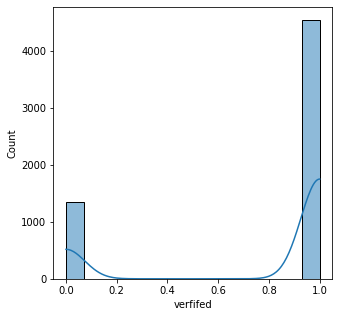

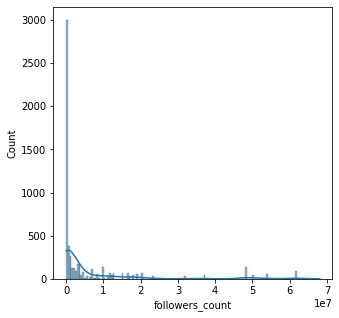

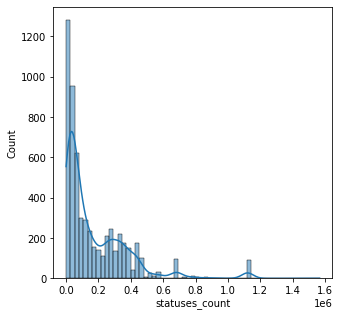

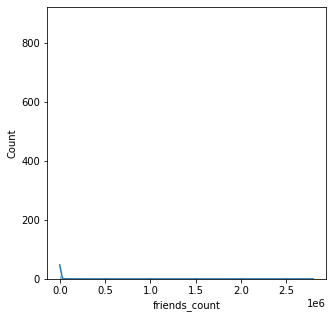

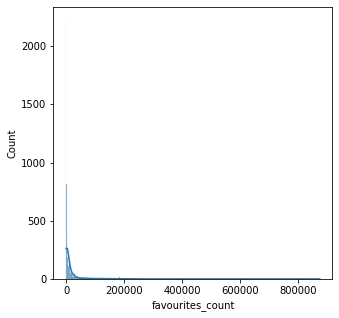

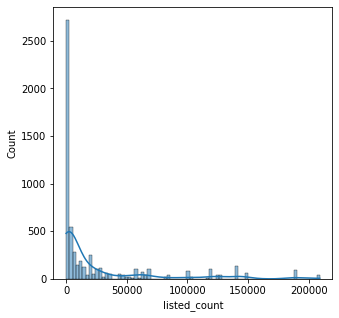

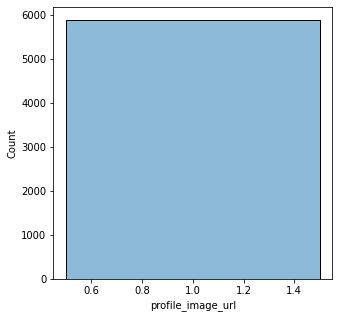

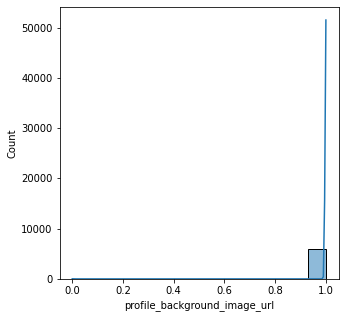

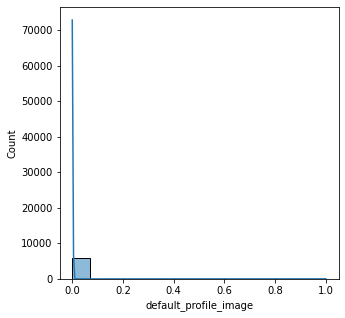

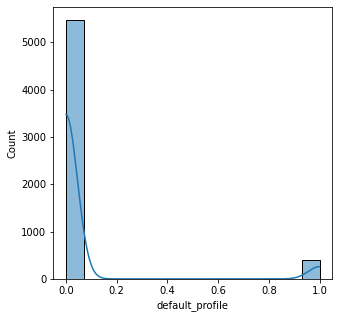

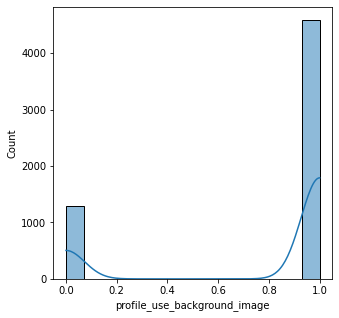

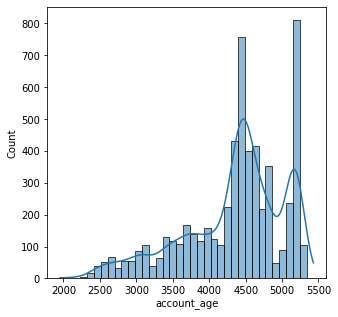

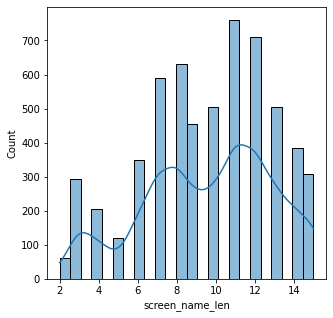

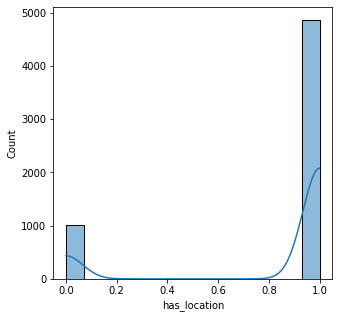

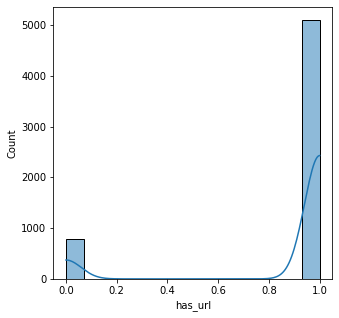

In [ ]:
cols = [ 'verfifed','followers_count', 'statuses_count', 
          'friends_count','favourites_count', 'listed_count',
          'profile_image_url', 'profile_background_image_url',
          'default_profile_image', 'default_profile','profile_use_background_image',
          'account_age', 'screen_name_len','has_location', 'has_url']

for col in cols:
  fig = plt.figure(figsize=(5,5))
  sns.histplot(user[col], kde=True)

In [ ]:
user[['followers_count', 'statuses_count','friends_count',
      'favourites_count', 'listed_count', 'account_age']] = user[['followers_count', 'statuses_count','friends_count',
      'favourites_count', 'listed_count', 'account_age']].apply(lambda x  : np.log(x+1))



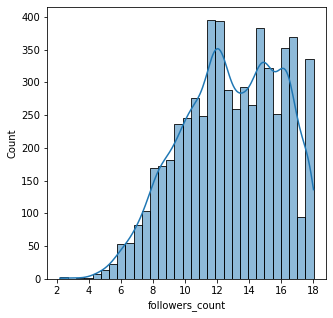

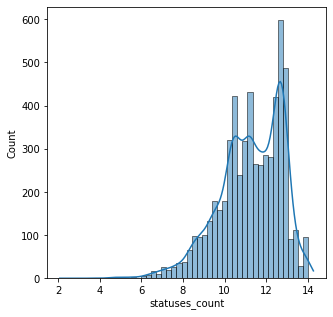

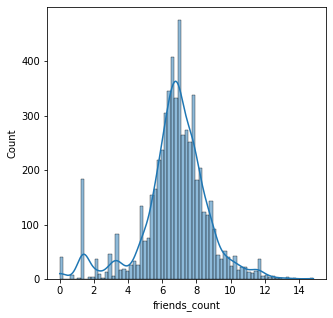

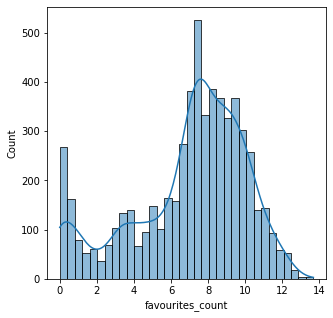

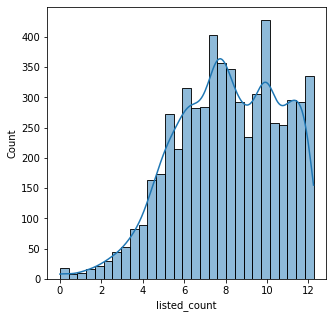

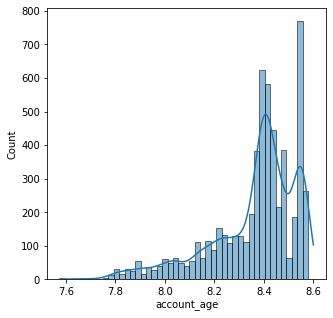

In [ ]:
cols  = ['followers_count', 'statuses_count','friends_count','favourites_count', 'listed_count', 'account_age']

for col in cols:
  fig = plt.figure(figsize=(5,5))
  sns.histplot(user[col], kde=True)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5877 entries, 0 to 5876
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   tweetId                 5877 non-null   int64         
 1   text                    5877 non-null   object        
 2   source                  5877 non-null   object        
 3   created_at              5877 non-null   datetime64[ns]
 4   is_reply                20 non-null     float64       
 5   retweet_count           5877 non-null   int64         
 6   favorite_count          5877 non-null   int64         
 7   is_quote_status         5877 non-null   bool          
 8   entities_symbols        5877 non-null   object        
 9   n_symbols               5877 non-null   int64         
 10  entities_user_mentions  5877 non-null   object        
 11  n_user_mentions         5877 non-null   int64         
 12  entities_hashtags       5877 non-null   object  

In [ ]:
# cleaning text data 

for i,v in enumerate(tweet['text']):
  tweet.loc[i,'text'] = p.clean(v)

def preprocess_data(data):
 #Removes Numbers
 data = data.astype(str).str.replace('\d+', '')
 lower_text = data.str.lower()
 lemmatizer = nltk.stem.WordNetLemmatizer()
 w_tokenizer =  TweetTokenizer()
 
 def lemmatize_text(text):
  return [(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))]

 def remove_punctuation(words):
    new_words = []
    for word in words:
      new_word = re.sub(r'[^\w\s]', '', (word))
      if new_word != '':
        new_words.append(new_word)
    return new_words

 words = lower_text.apply(lemmatize_text)
 words = words.apply(remove_punctuation)
 return pd.DataFrame(words)

pre_tweets = preprocess_data(tweet['text'])
tweet['text'] = pre_tweets
stop_words = set(stopwords.words('english'))
tweet['text'] = tweet['text'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])

In [ ]:
def analyze_sentiment(tweet):
  analysis = TextBlob(tweet)
  return analysis.sentiment.polarity

tweet['polarity'] =  tweet['text'].apply(lambda x : analyze_sentiment(' '.join(x)))

In [ ]:
tweet['is_reply'] = tweet['is_reply'].isnull()
tweet['is_reply'] = tweet['is_reply'].apply(lambda x : not x)
tweet['is_reply'] = tweet['is_reply'].astype(np.int64)

In [ ]:
tweet['is_quote_status'] = tweet['is_quote_status'].astype(np.int64)
tweet['text_len'] = tweet['text'].apply(len)
tweet['post_age'] = tweet['created_at'].apply(lambda x : (current_datetime-x).days)

In [ ]:
tweet.head(5)

,tweetId,text,source,created_at,is_reply,retweet_count,favorite_count,is_quote_status,entities_symbols,n_symbols,entities_user_mentions,n_user_mentions,entities_hashtags,n_hashtags,entities_url,n_url,label,polarity,text_len,post_age
0,552790074166108160,"[ten, dead, shooting, paris, office, satirical...",SocialFlow,2015-01-07 11:33:18,1,231,24,0,[],0,[],0,[],0,['http://trib.al/6smRXz6'],1,true,-0.021212,11,2336
1,723198441690636288,"[pop, legend, prince, ha, died]",SocialFlow,2016-04-21 17:15:19,1,1145,908,0,[],0,[],0,[],0,['http://eonli.ne/22QP2KW'],1,non-rumor,0.000000,5,1865
2,547803254516490240,"[able, float, jan, aka, zero, g, day, hint]",Tweetbot for Mac,2014-12-24 17:17:28,1,115,84,0,[],0,[],0,[],0,['http://www.slate.com/blogs/bad_astronomy/201...,1,false,0.500000,8,2349
3,553584292090359808,"[gunfire, explosion, heard, print, plant, nort...",TweetDeck,2015-01-09 16:09:14,1,117,53,0,[],0,[],0,"[{'text': 'CharlieHebdo', 'indices': [68, 81]}]",1,['http://bit.ly/14A14AX'],1,non-rumor,0.000000,10,2333
4,514057033419849728,"[alaskan, reporter, say, f, ck, quits, live, t...",Sprinklr,2014-09-22 14:22:02,1,149,211,0,[],0,[],0,[],0,['http://cosm.ag/6013oSCV'],1,true,0.136364,11,2442


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


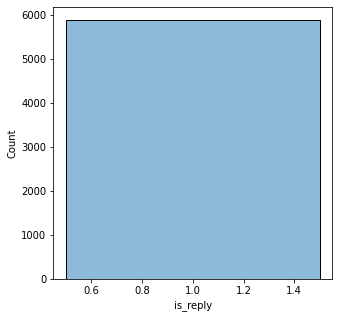

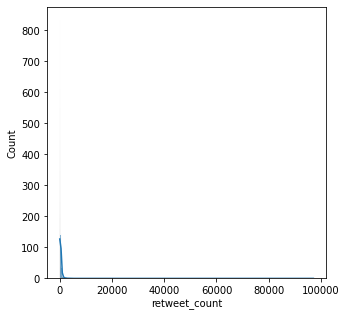

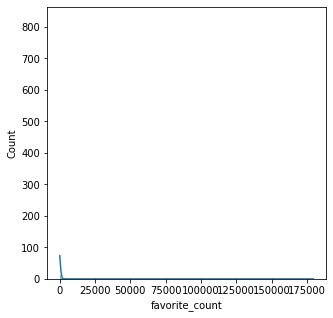

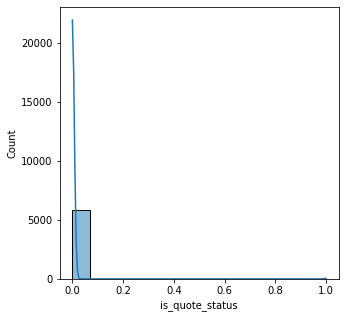

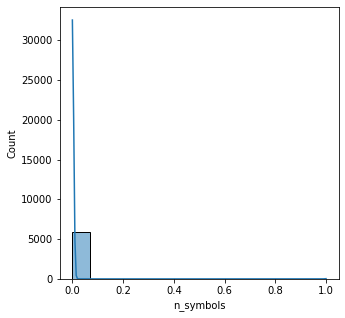

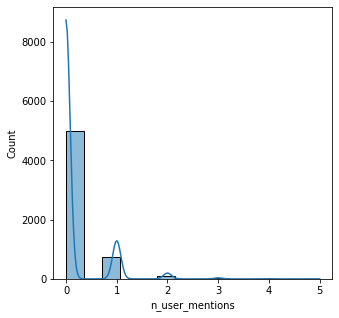

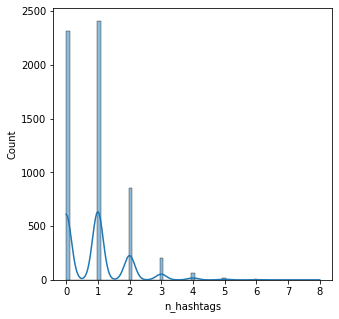

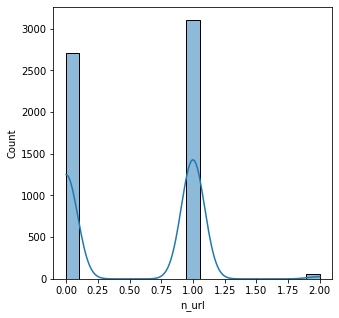

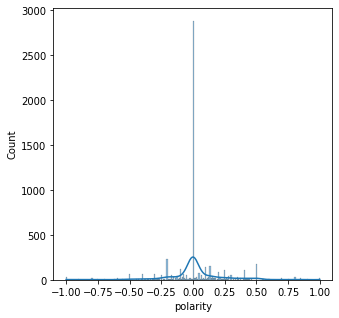

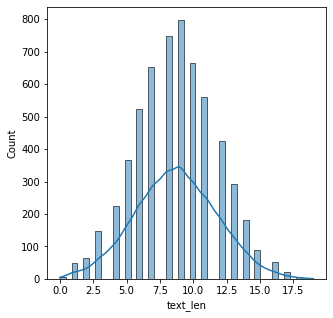

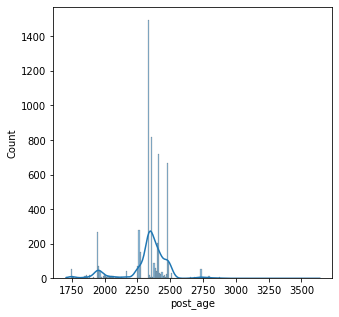

In [ ]:
cols = ['is_reply', 'retweet_count','favorite_count', 
        'is_quote_status', 'n_symbols', 'n_user_mentions',
       'n_hashtags','n_url', 'polarity','text_len', 'post_age']

for col in cols:
  fig = plt.figure(figsize=(5,5))
  sns.histplot(tweet[col], kde=True)

In [ ]:
tweet[['retweet_count','favorite_count','n_symbols', 'n_user_mentions',
       'n_hashtags']] = tweet[['retweet_count','favorite_count','n_symbols', 'n_user_mentions',
       'n_hashtags']].apply(lambda x : np.log(x+1))

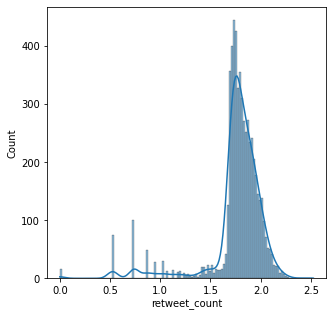

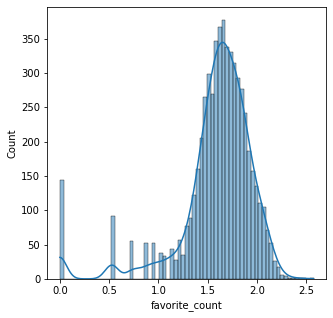

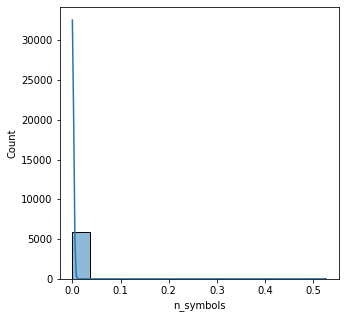

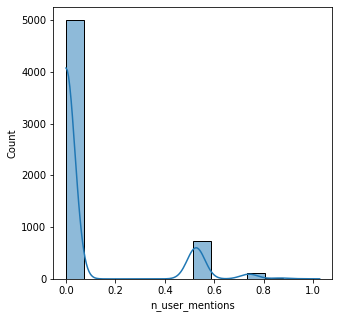

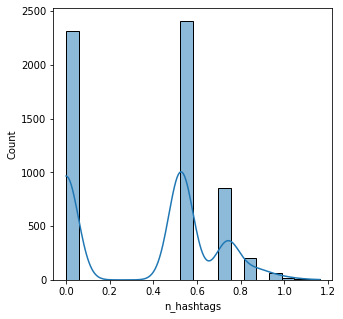

In [ ]:
cols = ['retweet_count','favorite_count','n_symbols', 'n_user_mentions',
       'n_hashtags']

for col in cols:
  fig = plt.figure(figsize=(5,5))
  sns.histplot(tweet[col], kde=True)

In [ ]:
merge = tweet.merge(user, on='tweetId', suffixes=['_tweet', '_user'])


In [ ]:
merge['posted_in'] = merge['created_at_tweet'] - merge['created_at_user']
merge['posted_in'] =  merge['posted_in'].apply(lambda x : x.days)

In [ ]:
merge.head()

,tweetId,text,source,created_at_tweet,is_reply,retweet_count,favorite_count,is_quote_status,entities_symbols,n_symbols,entities_user_mentions,n_user_mentions,entities_hashtags,n_hashtags,entities_url,n_url,label,polarity,text_len,post_age,userId,name,screen_name,verfifed,followers_count,statuses_count,friends_count,favourites_count,listed_count,location,created_at_user,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,url,account_age,screen_name_len,has_location,has_url,posted_in
0,552790074166108160,"[ten, dead, shooting, paris, office, satirical...",SocialFlow,2015-01-07 11:33:18,1,1.863574,1.439569,0,[],0.0,[],0.0,[],0.000000,['http://trib.al/6smRXz6'],1,true,-0.021212,11,2336,87818409,The Guardian,guardian,1,16.091867,13.419912,6.976348,4.927254,11.087130,London,2009-11-05 23:49:19,1,1,0,0,0,https://t.co/c53pnmnuIT,8.348775,8,1,1,1888
1,723198441690636288,"[pop, legend, prince, ha, died]",SocialFlow,2016-04-21 17:15:19,1,2.084931,2.055705,0,[],0.0,[],0.0,[],0.000000,['http://eonli.ne/22QP2KW'],1,non-rumor,0.000000,5,1865,2883841,E! News,enews,1,16.283268,12.518358,11.630380,10.279352,10.397482,"Hollywood, CA",2007-03-29 19:42:27,1,1,0,0,1,https://t.co/J6mkqdLswn,8.551981,5,1,1,3310
2,547803254516490240,"[able, float, jan, aka, zero, g, day, hint]",Tweetbot for Mac,2014-12-24 17:17:28,1,1.749824,1.694266,0,[],0.0,[],0.0,[],0.000000,['http://www.slate.com/blogs/bad_astronomy/201...,1,false,0.500000,8,2349,4620451,Phil Plait,BadAstronomer,1,13.339091,11.580752,6.202536,6.875232,9.414097,Boulder,2007-04-14 17:18:58,1,1,0,0,1,https://t.co/FZ6zYdPTeQ,8.548886,13,1,1,2810
3,553584292090359808,"[gunfire, explosion, heard, print, plant, nort...",TweetDeck,2015-01-09 16:09:14,1,1.752791,1.607232,0,[],0.0,[],0.0,"[{'text': 'CharlieHebdo', 'indices': [68, 81]}]",0.526589,['http://bit.ly/14A14AX'],1,non-rumor,0.000000,10,2333,1367531,Fox News,FoxNews,1,16.820711,12.961255,5.564520,1.098612,11.136033,U.S.A.,2007-03-17 19:01:26,1,1,0,0,1,http://t.co/ZYG58XZtAC,8.554296,7,1,1,2854
4,514057033419849728,"[alaskan, reporter, say, f, ck, quits, live, t...",Sprinklr,2014-09-22 14:22:02,1,1.793530,1.849491,0,[],0.0,[],0.0,[],0.000000,['http://cosm.ag/6013oSCV'],1,true,0.136364,11,2442,23482952,Cosmopolitan,Cosmopolitan,1,14.294997,12.336302,7.809135,9.934647,8.881558,"New York, NY",2009-03-09 19:11:03,1,1,0,0,1,https://t.co/y65SHhxl9k,8.404248,12,1,1,2022


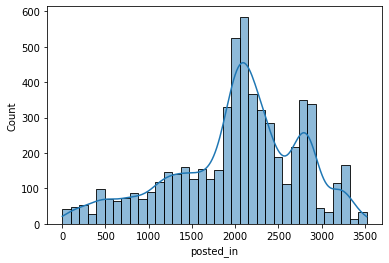

In [ ]:
sns.histplot(merge['posted_in'], kde=True)

In [ ]:
df = merge[['is_reply','verfifed', 'followers_count',
       'retweet_count', 'favorite_count', 'is_quote_status', 'n_symbols', 
       'n_user_mentions', 'n_hashtags','n_url', 'polarity', 'text_len', 'post_age',
       'statuses_count', 'friends_count', 'favourites_count', 'listed_count',
       'profile_image_url', 'profile_background_image_url', 'default_profile_image',
       'default_profile', 'profile_use_background_image', 'account_age',
       'screen_name_len', 'has_location', 'has_url', 'posted_in', 'label']]

In [ ]:
df.head()

,is_reply,verfifed,followers_count,retweet_count,favorite_count,is_quote_status,n_symbols,n_user_mentions,n_hashtags,n_url,polarity,text_len,post_age,statuses_count,friends_count,favourites_count,listed_count,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,account_age,screen_name_len,has_location,has_url,posted_in,label
0,1,1,16.091867,1.863574,1.439569,0,0.0,0.0,0.000000,1,-0.021212,11,2336,13.419912,6.976348,4.927254,11.087130,1,1,0,0,0,8.348775,8,1,1,1888,true
1,1,1,16.283268,2.084931,2.055705,0,0.0,0.0,0.000000,1,0.000000,5,1865,12.518358,11.630380,10.279352,10.397482,1,1,0,0,1,8.551981,5,1,1,3310,non-rumor
2,1,1,13.339091,1.749824,1.694266,0,0.0,0.0,0.000000,1,0.500000,8,2349,11.580752,6.202536,6.875232,9.414097,1,1,0,0,1,8.548886,13,1,1,2810,false
3,1,1,16.820711,1.752791,1.607232,0,0.0,0.0,0.526589,1,0.000000,10,2333,12.961255,5.564520,1.098612,11.136033,1,1,0,0,1,8.554296,7,1,1,2854,non-rumor
4,1,1,14.294997,1.793530,1.849491,0,0.0,0.0,0.000000,1,0.136364,11,2442,12.336302,7.809135,9.934647,8.881558,1,1,0,0,1,8.404248,12,1,1,2022,true


In [ ]:
df['label'].value_counts()

non-rumor     3242
true          1113
false          826
unverified     696
Name: label, dtype: int64

In [ ]:
df.loc[:, 'label'] = df['label'].replace({'non-rumor':False, 'true':True, 'false':True, 'unverified':True})
df['label'] = df['label'].astype(np.int64)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,is_reply,verfifed,followers_count,retweet_count,favorite_count,is_quote_status,n_symbols,n_user_mentions,n_hashtags,n_url,polarity,text_len,post_age,statuses_count,friends_count,favourites_count,listed_count,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,account_age,screen_name_len,has_location,has_url,posted_in,label
0,1,1,16.091867,1.863574,1.439569,0,0.0,0.0,0.000000,1,-0.021212,11,2336,13.419912,6.976348,4.927254,11.087130,1,1,0,0,0,8.348775,8,1,1,1888,1
1,1,1,16.283268,2.084931,2.055705,0,0.0,0.0,0.000000,1,0.000000,5,1865,12.518358,11.630380,10.279352,10.397482,1,1,0,0,1,8.551981,5,1,1,3310,0
2,1,1,13.339091,1.749824,1.694266,0,0.0,0.0,0.000000,1,0.500000,8,2349,11.580752,6.202536,6.875232,9.414097,1,1,0,0,1,8.548886,13,1,1,2810,1
3,1,1,16.820711,1.752791,1.607232,0,0.0,0.0,0.526589,1,0.000000,10,2333,12.961255,5.564520,1.098612,11.136033,1,1,0,0,1,8.554296,7,1,1,2854,0
4,1,1,14.294997,1.793530,1.849491,0,0.0,0.0,0.000000,1,0.136364,11,2442,12.336302,7.809135,9.934647,8.881558,1,1,0,0,1,8.404248,12,1,1,2022,1


# Correlation and Feature Selection

In [ ]:
num_features = ['followers_count','retweet_count', 'favorite_count', 'n_symbols', 
       'n_user_mentions', 'n_hashtags','n_url', 'polarity', 'text_len', 'post_age',
       'statuses_count', 'friends_count', 'favourites_count', 'listed_count',
        'account_age','screen_name_len','posted_in']

cat_features = ['is_reply','verfifed','is_quote_status','profile_image_url', 'profile_background_image_url', 'default_profile_image',
       'default_profile', 'profile_use_background_image','has_location', 'has_url']

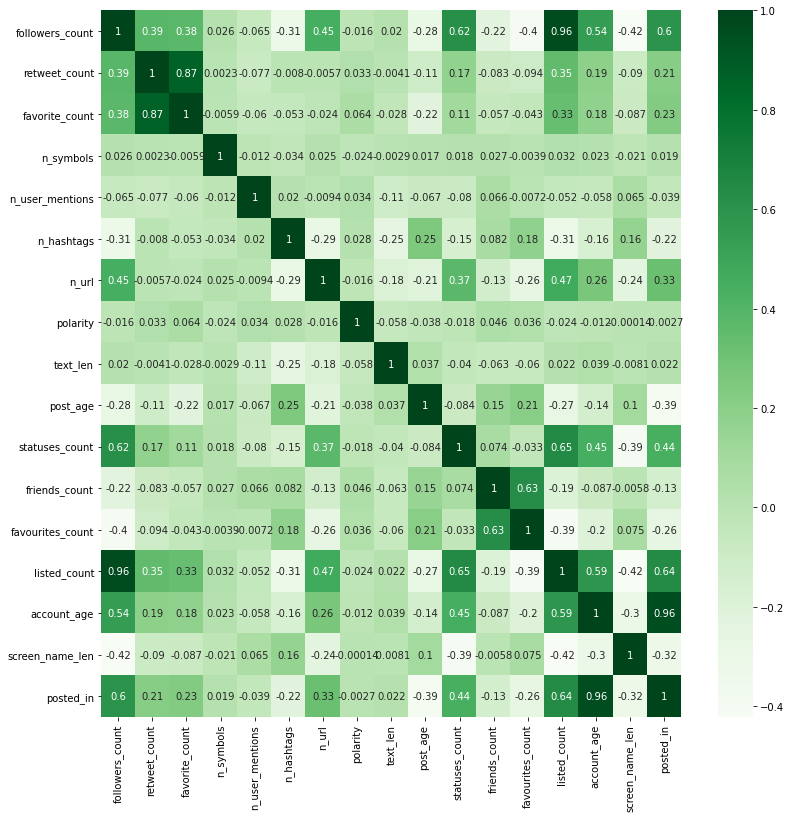

In [ ]:
num_features_corr_matrix = df[num_features].corr()
fig = plt.figure(figsize=(13,13))
sns.heatmap(num_features_corr_matrix, annot =True, cmap=plt.cm.Greens)

In [ ]:
X = df.drop('label', axis=1)
y = df['label']

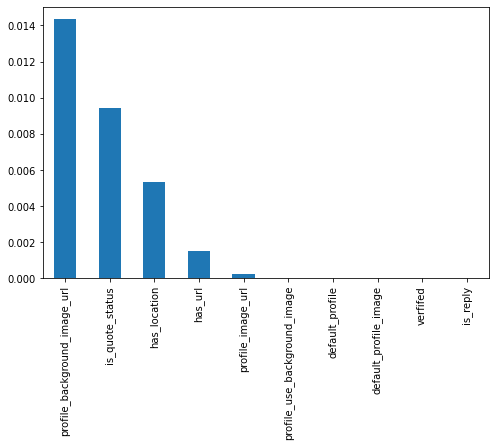

In [ ]:
# mutual information

from sklearn.feature_selection import mutual_info_classif
# from sklearn.feature_extraction import SelectKBest

mutual_info = mutual_info_classif(X[cat_features],y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X[cat_features].columns

mutual_info.sort_values(ascending=False).plot.bar(figsize=(8,5))


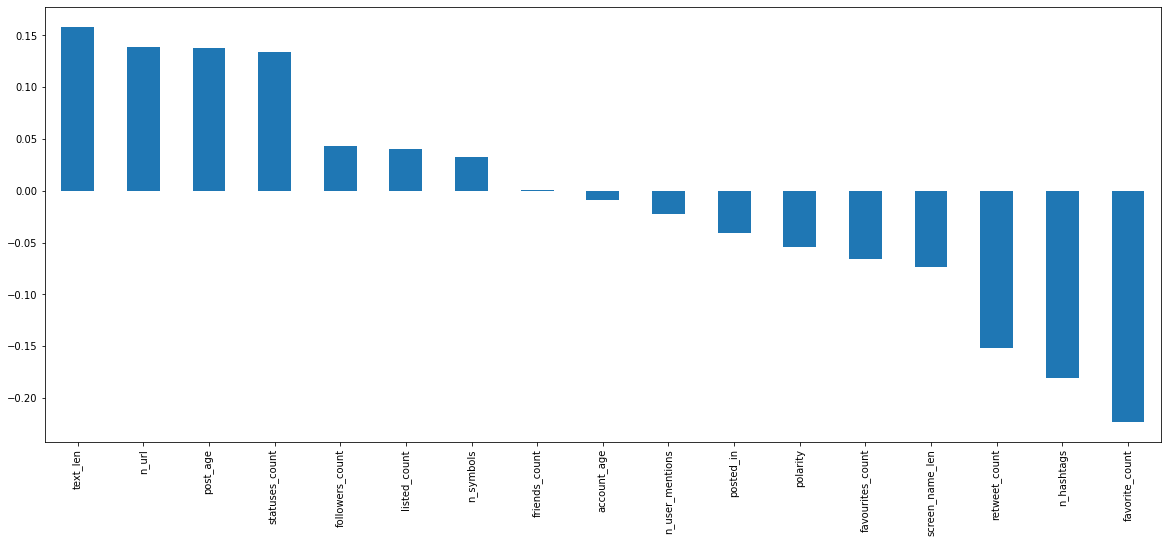

In [ ]:
# Point Biserial  Correlation 
# numerical independent -> dependent binary categorical
pbc_res = {}
for col in num_features:
  pbc = pointbiserialr(df[col], df['label'])
  pbc_res[col] = pbc.correlation

pbc = pd.Series(pbc_res)
pbc.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
selected_features = ['profile_use_background_image','profile_background_image_url',
                     'default_profile_image','default_profile','verfifed', 'text_len',
                     'n_url', 'post_age', 'statuses_count', 'listed_count', 'n_symbols',
                     'posted_in', 'n_user_mentions', 'polarity', 'favourites_count', 'favorite_count',
                     'screen_name_len', 'n_hashtags']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
X_train.head()

,profile_use_background_image,profile_background_image_url,default_profile_image,default_profile,verfifed,text_len,n_url,post_age,statuses_count,listed_count,n_symbols,posted_in,n_user_mentions,polarity,favourites_count,favorite_count,screen_name_len,n_hashtags
2828,1,1,0,0,1,10,0,2412,9.663643,6.496775,0.0,1974,0.000000,0.00,8.363809,1.343703,12,0.526589
5375,1,1,0,0,1,6,1,2359,12.696357,11.727803,0.0,2874,0.000000,0.15,2.639057,1.618011,8,0.526589
1771,1,1,0,0,1,11,1,2260,11.089256,7.804251,0.0,440,0.526589,0.00,6.791221,1.223156,10,0.000000
5203,1,1,0,0,1,9,1,2436,11.829618,9.713718,0.0,224,0.000000,0.00,8.254529,1.646667,9,0.000000
2585,1,1,0,0,0,10,0,2359,10.945335,5.638355,0.0,1367,0.000000,0.00,9.854875,1.871996,13,0.526589


# Model

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
sel_num_features = ['text_len','n_url', 'post_age', 'statuses_count', 'listed_count', 'n_symbols',
                     'posted_in', 'n_user_mentions', 'polarity', 'favourites_count', 'favorite_count',
                     'screen_name_len', 'n_hashtags']

sel_cat_features = ['profile_use_background_image','profile_background_image_url',
                     'default_profile_image','default_profile','verfifed']

#check if already run before running
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ct = ColumnTransformer([('standard_scaler', StandardScaler(), sel_num_features),
#                         ('OneHotEncoder', OneHotEncoder(drop='first'), sel_cat_features)])

# X_train_scaled = ct.fit_transform(X_train, y_train)
sc_x = StandardScaler()

X_train[sel_num_features] = sc_X.fit_transform(X_train[sel_num_features])
X_test[sel_num_features] = sc_X.fit_transform(X_test[sel_num_features])


In [ ]:
X_train_scaled = X_train
X_test_scaled = X_test

In [ ]:
X_train_scaled.shape

(4701, 18)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# X_train_mm = scaler.fit_transform(X_train)
# X_test_mm = scaler.fit(X_test)

In [ ]:
metrics = pd.DataFrame(columns=['model' ,'f1 score', 'train accuracy','test accuracy'])
random_state = 42
models=[
        XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        #MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]

In [ ]:
def fit_and_predict(model,x_train,x_test,y_train,y_test):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(model))
    plt.show()


    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                             },
                               ignore_index=True
                            )

    print(classification_report(y_test,y_pred))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


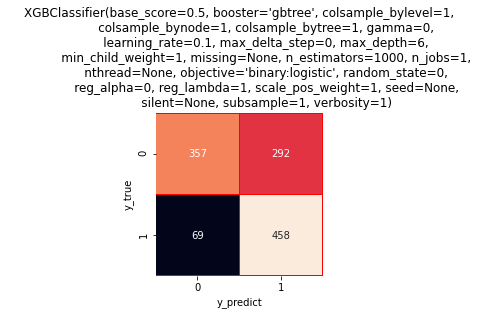

              precision    recall  f1-score   support

           0       0.84      0.55      0.66       649
           1       0.61      0.87      0.72       527

    accuracy                           0.69      1176
   macro avg       0.72      0.71      0.69      1176
weighted avg       0.74      0.69      0.69      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:69%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


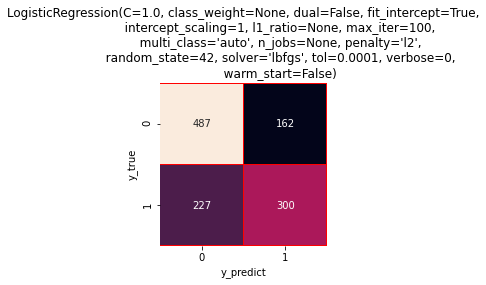

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       649
           1       0.65      0.57      0.61       527

    accuracy                           0.67      1176
   macro avg       0.67      0.66      0.66      1176
weighted avg       0.67      0.67      0.67      1176

Accuracy of classifier on training set:69%
Accuracy of classifier on test set:67%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


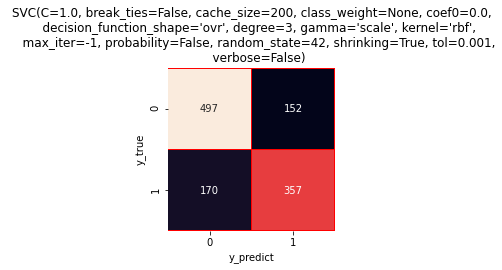

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.70      0.68      0.69       527

    accuracy                           0.73      1176
   macro avg       0.72      0.72      0.72      1176
weighted avg       0.73      0.73      0.73      1176

Accuracy of classifier on training set:76%
Accuracy of classifier on test set:73%


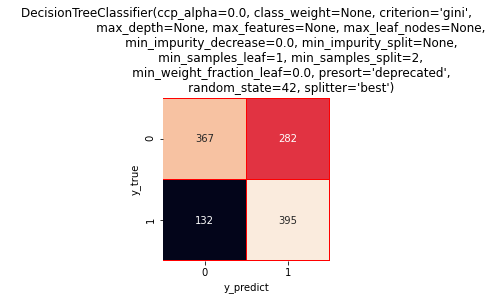

              precision    recall  f1-score   support

           0       0.74      0.57      0.64       649
           1       0.58      0.75      0.66       527

    accuracy                           0.65      1176
   macro avg       0.66      0.66      0.65      1176
weighted avg       0.67      0.65      0.65      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:65%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


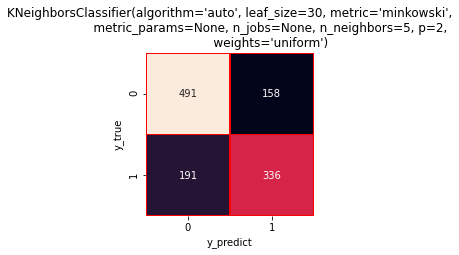

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       649
           1       0.68      0.64      0.66       527

    accuracy                           0.70      1176
   macro avg       0.70      0.70      0.70      1176
weighted avg       0.70      0.70      0.70      1176

Accuracy of classifier on training set:80%
Accuracy of classifier on test set:70%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


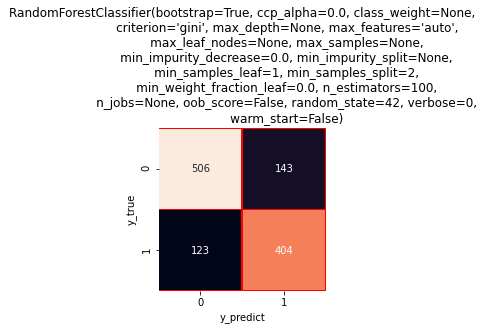

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       649
           1       0.74      0.77      0.75       527

    accuracy                           0.77      1176
   macro avg       0.77      0.77      0.77      1176
weighted avg       0.77      0.77      0.77      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:77%


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metric
for model in models:
  fit_and_predict(model,X_train_scaled,X_test_scaled,y_train,y_test)

# Neural Network

In [ ]:
from keras.layers import Dense, Activation,Embedding,Flatten,LeakyReLU,BatchNormalization,Dropout
from keras.activations import relu,sigmoid
from keras.layers import LeakyReLU

from keras.models import Sequential
from keras.layers import Dense

from keras.regularizers import l2
import tensorflow as tf

In [ ]:

model2 = Sequential()
model2.add(Dense(64, input_dim=X_train.shape[1], activation='relu' , activity_regularizer=l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model2.add(Dropout(0.3))
model2.add(Dense(1,kernel_initializer='glorot_uniform',activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkPoint = ModelCheckpoint("/content/drive/MyDrive/Rumor Detection/models/user_tweet_metaData_model", mode='min')
es_callback = EarlyStopping(monitor='val_loss', patience=10,mode='min')
callbacks = [PlotLossesKeras(), es_callback]


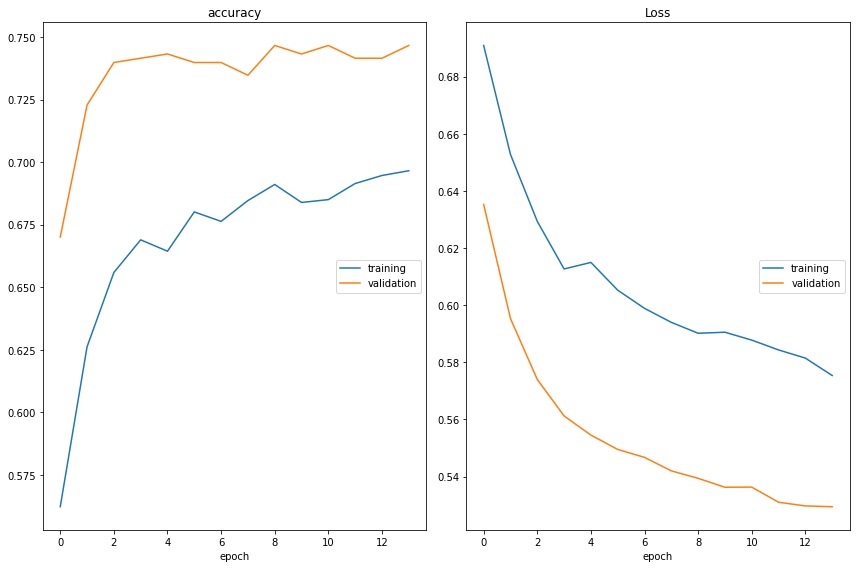

accuracy
	training         	 (min:    0.562, max:    0.697, cur:    0.697)
	validation       	 (min:    0.670, max:    0.747, cur:    0.747)
Loss
	training         	 (min:    0.575, max:    0.691, cur:    0.575)
	validation       	 (min:    0.529, max:    0.635, cur:    0.529)
Epoch 15/150


KeyboardInterrupt: ignored

In [ ]:
# # Kfold validation
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler

# acc_per_fold = []
# loss_per_fold = []
# num_folds = 10


# kfold = KFold(n_splits=num_folds, shuffle=True)

# inp_x =  X[selected_features]
# inp_y = y
# fold_no = 1

# for train, test in kfold.split(inp_x, inp_y):

#   sc_X = StandardScaler()
#   X_train_scaled = sc_X.fit_transform(inp_x.loc[train, :])
#   X_test_scaled = sc_X.transform(inp_x.loc[test, :])


#   model4 = tf.keras.Sequential([
#     Dense(64, input_dim=inp_x.shape[1], activation='relu' , activity_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(64,activation='relu',activity_regularizer=l2(0.01)),
#     Dropout(0.3),
#     Dense(1,kernel_initializer='glorot_uniform',activation='sigmoid'),
#   ])

#   model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#   print('------------------------------------------------------------------------')
#   print(f'Training for fold {fold_no} ...')

#   # Fit data to model
#   es_callback = EarlyStopping(monitor='val_loss', patience=10,mode='min')
#   callbacks = [PlotLossesKeras(), es_callback]
#   history = model4.fit(X_train_scaled,
#                        inp_y[train],
#                        batch_size=256,
#                         epochs=150,
#                         verbose=1,
#                         callbacks=callbacks,
#                         validation_data=(X_test_scaled,inp_y[test]))

#   # Generate generalization metrics
#   scores = model4.evaluate(X_test_scaled, inp_y[test], verbose=1)
#   print(f'Score for fold {fold_no}: {model4.metrics_names[0]} of {scores[0]}; {model4.metrics_names[1]} of {scores[1]*100}%')
#   acc_per_fold.append(scores[1] * 100)
#   loss_per_fold.append(scores[0])

#   # Increase fold number
#   fold_no = fold_no + 1

# # == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#   print('------------------------------------------------------------------------')
#   print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')

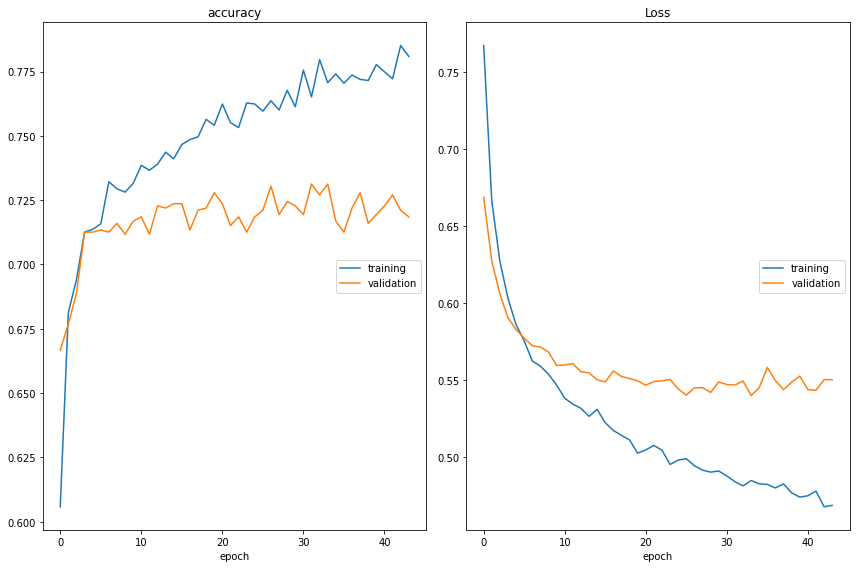

accuracy
	training         	 (min:    0.606, max:    0.785, cur:    0.781)
	validation       	 (min:    0.667, max:    0.731, cur:    0.719)
Loss
	training         	 (min:    0.468, max:    0.767, cur:    0.469)
	validation       	 (min:    0.540, max:    0.669, cur:    0.550)


In [ ]:
model2.fit(X_train_scaled,
           y_train, 
           epochs=100,
           batch_size=32,
           validation_data=(X_test_scaled, y_test),

           callbacks = callbacks)

In [ ]:
from pprint import pprint

for i, layer in  enumerate(model2.layers):
  print('layer {}'.format(i), layer)
  pprint(layer.get_weights())

layer 0 <keras.layers.core.Dense object at 0x7f43af1d5b50>
[array([[ 0.03753324, -0.16023937, -0.13677382, ..., -0.21433364,
        -0.18447828,  0.12315641],
       [-0.1538444 , -0.05571688, -0.37023014, ..., -0.34591416,
        -0.34823424, -0.3279718 ],
       [-0.00257686,  0.09112155,  0.51495725, ..., -0.20442763,
         0.06271097, -0.15164126],
       ...,
       [ 0.11953152,  0.2427849 , -0.01356205, ...,  0.22312555,
        -0.03704426,  0.03952525],
       [-0.041819  ,  0.03537462,  0.05393235, ...,  0.06224958,
         0.10518032,  0.1060654 ],
       [ 0.05166892,  0.02685543, -0.07053435, ...,  0.28054023,
         0.18310489, -0.01597518]], dtype=float32),
 array([-0.12327721, -0.05271833, -0.23246188, -0.16373676, -0.13253362,
       -0.22687878, -0.08865776, -0.23517479, -0.32358545, -0.20174389,
       -0.2595107 , -0.24697828, -0.08881546, -0.19958092, -0.17026676,
       -0.3119088 , -0.25182283, -0.22105819, -0.21953823, -0.16096786,
       -0.15541063, -0

In [ ]:
# save model
model2.save('/content/drive/MyDrive/Rumor Detection/models/all_models/user_tweet_meta_data.h5')

In [ ]:
# load model
from tensorflow.keras.models import load_model
temp = load_model('/content/drive/MyDrive/Rumor Detection/models/all_models/user_tweet_meta_data.h5')

In [ ]:
# for i, layer in  enumerate(temp.layers):
#   print('layer {}'.format(i), layer)
#   pprint(layer.get_weights())

In [ ]:
temp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stdScaler = StandardScaler()
X_temp = stdScaler.fit_transform(X[selected_features]) 
y_temp = y

In [ ]:
temp.evaluate(X_temp, y_temp)

184/184 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7984


[0.44530177116394043, 0.7983664870262146]

In [ ]:
temp.evaluate(X_test_scaled, y_test)

37/37 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.7372


[0.5444868803024292, 0.7372449040412903]